In [1]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from scipy.signal import find_peaks
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import math
from operator import add
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
from skimage.feature import peak_local_max
from scipy.ndimage.morphology import distance_transform_edt as edt
from IPython.display import clear_output
import timeit
import cv2
import skvideo.io
from PIL import Image
from cv2 import VideoWriter, VideoWriter_fourcc
from scipy.signal import find_peaks
import peakutils
import png #pip install pypng
import os

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(20, 20))
mpl.rc('image', cmap='gray')
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

#Image Loading
str1 = 'images/'
date = '25_03_19'
name = 'Cd_dots and gCAMP_dish2/mov1'
other = '/ch02/'# non_normalised for dots, dyeChannel for dyes
extension = '*.tif'
path = str1+date+'/'+name+other+extension

frames = pims.ImageSequence(path, as_grey=True)

In [2]:
total_frames = len(frames)

image1= np.int64(frames[0])
for frameNum in range(1, total_frames-1):
    image1 = image1-np.int64(frames[frameNum])

image1[image1 > np.amin(image1)*0.1] = 0
image1[image1 < np.amin(image1)*0.9] = 0
im = edt(image1)
   
roi_size = 8

coordinates = peak_local_max(im, min_distance=roi_size*1,threshold_rel = 0.02)

def collect(x, y, sigma):
    neighborhood = []
    X = int(sigma)
    for i in range(-X, X + 1):
        Y = int(pow(sigma * sigma - i * i, 1/2))
        for j in range(-Y, Y + 1):
            neighborhood.append((x + i, y + j))
    return neighborhood

good_coordinates = coordinates[np.array([65,121,120,84,100,99,96])]
#good_coordinates = coordinates#[np.array([0,10,11,12,13,14,15,17,20,24,28,36,37,38])]

total_particles = len(good_coordinates)
particle_index = np.linspace(0,total_particles-1,total_particles,dtype='int')
particle_coords = [0] * total_frames
particle_roi_dict = dict(zip(particle_index, particle_coords))

for index, shift in enumerate(good_coordinates):
    current_coords = [0,0]
    centre_x = shift[1]
    centre_y = shift[0] 
    particle_roi_dict[index] = collect(int(centre_x), int(centre_y), roi_size)

In [3]:
# Dye Work:

#Image Loading
str1 = 'images/'
date = '25_03_19'
name = 'Cd_dots and gCAMP_dish2/mov1'
other = '/ch00/'# non_normalised for dots, dyeChannel for dyes
extension = '*.tif'
path = str1+date+'/'+name+other+extension

frames = pims.ImageSequence(path, as_grey=True)


for key1, value1 in enumerate(frames):
    fig = pp.figure()
    pp.imshow(value1, cmap=pp.cm.gray)
    pp.autoscale(False)
    pp.axis('off')
    pp.plot(good_coordinates[:,1],good_coordinates[:,0],'r,')
    for xy in zip(good_coordinates[:,1], good_coordinates[:,0]):                                      
        pp.annotate('X', xy=xy,color='white',xytext=xy)
    path = "videos/"
    fname = str(key1)+".png"
    fig.savefig(path+fname, bbox_inches='tight',dpi = 200)
    pp.close('all')

In [4]:
len(frames)

83

7


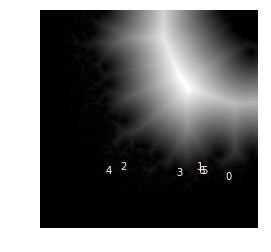

In [5]:
pp.figure()
pp.imshow(im, cmap=pp.cm.gray)
pp.autoscale(False)
pp.axis('off')

print(len(good_coordinates))

pp.plot(good_coordinates[:,1],good_coordinates[:,0],'r,')

z=0
for xy in zip(good_coordinates[:,1], good_coordinates[:,0]):                                      
    pp.annotate(str(z), xy=xy,color='white',xytext=xy) 
    z = z+1

In [288]:
# noParticles = len(particle_roi_dict)

frame_index = np.linspace(0,total_frames-1,total_frames,dtype='int')
frame_intensity = [0] * total_frames
overall_dict = dict(zip(frame_index, frame_intensity))

start = timeit.default_timer()
   
for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
    clear_output(wait=True)
    current_particle_intensity = 0
    particle_dict = dict()
    for key0, value0 in enumerate(particle_roi_dict): #Key0: particle number
        a = np.asarray(particle_roi_dict[key0])
        particle_dict[key0] = np.sum(value1[a[:,0],a[:,1]])
    overall_dict[key1] = particle_dict
        
    stop = timeit.default_timer()
    if (key1/len(frames)*100) <5 :
        expected_time = "Calculating..."
    else:
        time_perc = timeit.default_timer()
        expected_time = np.round(((time_perc-start)/(key1/len(frames)))/60,2)
    print("Current progress:",np.round(key1/len(frames)*100,2),"%")
    print("Current run time:",np.round((stop-start)/60,2),"minutes")
    print("Expected run time:",expected_time,"minutes")
    
new_overall_dict = dict()
for key0 in range(0,len(overall_dict[0])): #key1: particle number
    new_current_particle = dict()
    for key1 in range(0,len(overall_dict)): #key1: frame number
        new_current_particle[key1]=overall_dict[key1][key0]
    new_overall_dict[key0] = new_current_particle
    

Current progress: 99.71 %
Current run time: 0.33 minutes
Expected run time: 0.33 minutes


In [289]:
summed_dict = dict()
for key0, val0 in enumerate(overall_dict): #key1: particle number
    summed_dict[key0] = sum(overall_dict[key0].values())

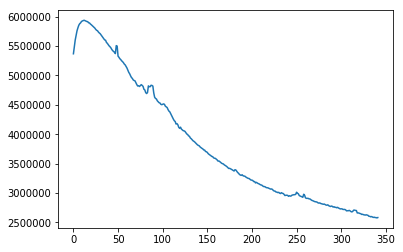

In [290]:
pp.plot(summed_dict.keys(),summed_dict.values())

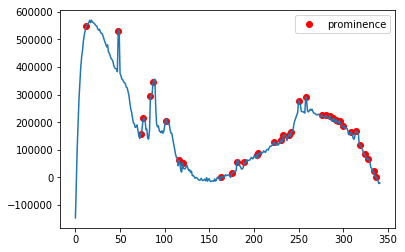

array([ 12,  48,  73,  76,  84,  87, 101, 116, 120, 163, 175, 181, 189,
       203, 205, 222, 230, 233, 239, 242, 250, 258, 276, 281, 285, 289,
       292, 294, 296, 300, 309, 314, 319, 324, 328, 334, 337])

In [291]:
dot_values = np.array(summed_dict.values())

peaks, _ = find_peaks(dot_values, prominence=1000)

dot_values_cut = np.subtract(dot_values,peakutils.baseline(dot_values))

pp.plot(peaks, dot_values_cut[peaks], "or"); 
pp.plot(dot_values_cut); 
pp.legend(['prominence'])
pp.show()
peaks

In [292]:
print(grid_y)

2


In [ ]:
coord_len = len(good_coordinates)-2
grid_x = int(math.sqrt(coord_len))
grid_y = int(coord_len/grid_x)
roi_size = 20

img_array = []
f_x = []
f_xy = []
f = []
start = timeit.default_timer()
for indx in range(0,len(frames)-1):
    clear_output(wait=True)
    for g_y in range(0,grid_y):
        for g_x in range(0,grid_x):         
            coords = (g_x)+((g_y)*grid_y)
            f = frames[indx][good_coordinates[coords][0]-roi_size:good_coordinates[coords][0]+roi_size, good_coordinates[coords][1]-roi_size:good_coordinates[coords][1]+roi_size]   
            if f.size ==0:
                coords = coords-1
                f = frames[indx][good_coordinates[coords][0]-roi_size:good_coordinates[coords][0]+roi_size, good_coordinates[coords][1]-roi_size:good_coordinates[coords][1]+roi_size]
            if g_x == 0:
                f_x = f
            else:
                f_x = np.hstack([f_x,f])
        if g_y ==0:
            f_xy = f_x
        else:
            f_xy = np.vstack([f_xy,f_x])
            f_x = []
    img_array.append(f_xy)
    f_xy = []
    
    stop = timeit.default_timer()
    if (indx/(len(frames)-1)*100) <5 :
        expected_time = "Calculating..."
    else:
        time_perc = timeit.default_timer()
        expected_time = np.round(((time_perc-start)/(indx/len(frames)))/60,2)
    print("Current progress:",np.round(indx/len(frames)*100,2),"%")
    print("Current run time:",np.round((stop-start)/60,2),"minutes")
    print("Expected run time:",expected_time,"minutes")

Current progress: 57.89 %
Current run time: 21.01 minutes
Expected run time: 36.29 minutes


In [296]:
for i in range(len(img_array)):
    #im = Image.fromarray(img_array[i])
    #im = Image.fromarray(img_array[i], 'I')
    path = "videos/"
    fname = str(i)+".png"
    #im.save(path+fname)
    png.from_array(img_array[i], 'L').save(path+fname)